# Models with Keras

Trains models on synthetic data .

In [6]:
import sys
sys.path.append('../..')


In [7]:
import tensorflow as tf
from numpy import arange
import tensorflow_datasets as tfds


In [10]:
from model_compra_comigo.experimenter import Experimenter
from model_compra_comigo.data_handler.data_simulator import DataSimulator
from model_compra_comigo.data_handler import DataHandler
from model_compra_comigo.data_handler.utils import plot_series


In [11]:
data_simulator = DataSimulator()
data_handler = DataHandler()


## Generate a Dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


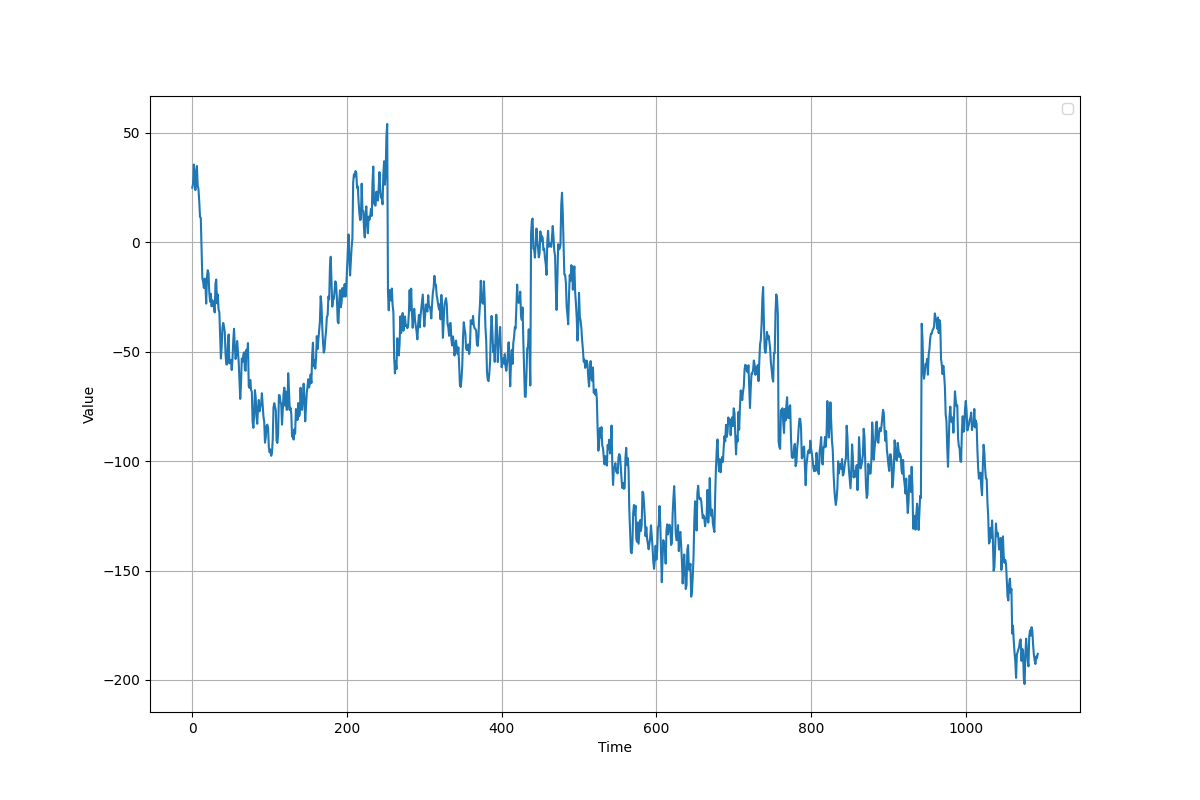

In [54]:
time_range = 365*3
split = 365
time_data = arange(time_range)

series, parameters = data_simulator.generate(
    time_range = time_range,
)

labels=[(f"trend_slope = {parameters['trend_slope']}\n"
         f"seasonality_period = {parameters['seasonality_period']}\n"
         f"seasonality_amplitude = {parameters['seasonality_amplitude']}\n"
         f"seasonality_phase = {parameters['seasonality_phase']}\n"
         f"seasonality_time_threshold = {parameters['seasonality_time_threshold']}\n"
         f"seasonality_ncos = {parameters['seasonality_ncos']}\n"
         f"seasonality_nexp = {parameters['seasonality_nexp']}\n"
         f"noise_scaling_factor = {parameters['noise_scaling_factor']}\n"
         f"autocorrelation_amplitude = {parameters['autocorrelation_amplitude']}\n"
         f"autocorrelation_phi = {parameters['autocorrelation_phi']}"
        )]

data_handler.plot_series(
    time=time_data,
    series=series,
    labels=labels
)


## Creates Windowed Dataset with N forecasts

In [55]:
window_size = 30
nforecast = 20
batch_size = 32
shuffle_buffer_size = 10000


In [56]:
train_size=300
dataset=series

In [57]:
data = data_handler.generate_windowed_dataset(
    data = series,
    window_size = window_size,
    batch_size = batch_size,
    shuffle_buffer_size = shuffle_buffer_size,
    nforecast = nforecast,
    shuffle = True
)


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, TimeDistributed, GRU

In [59]:
# Define the dataset creation function
def create_dataset(data, window_size, n):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size + n, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + n))
    dataset = dataset.map(lambda window: (window[:-n], window[-n:])).shuffle(buffer_size=100)
    return dataset

dataset = create_dataset(series, window_size, nforecast)

inputs = []
targets = []

for input_seq, target_seq in dataset:
    inputs.append(input_seq.numpy())
    targets.append(target_seq.numpy())

inputs_ts = tf.convert_to_tensor(inputs)
targets_ts = tf.convert_to_tensor(targets)


2023-07-25 07:02:12.333381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1095]
	 [[{{node Placeholder/_0}}]]
2023-07-25 07:02:12.334129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1095]
	 [[{{node Placeholder/_0}}]]


In [60]:
import numpy as np

In [61]:
inp = np.array(inputs)
inp = inp.reshape(inp.shape[0], inp.shape[1], 1)
inp.shape

(1046, 30, 1)

In [62]:
t = np.array(targets)
t = t.reshape(t.shape[0], t.shape[1], 1)
t.shape

(1046, 20, 1)

In [63]:
i = 0
for element in dataset:
  print(element)
  i = i + 1
i

(<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([-53.46104984, -44.8335132 , -39.51598547, -47.70648874,
       -53.32808099, -51.19783676, -45.09986945, -49.79186939,
       -54.51002167, -62.63956677, -71.58715818, -64.8448447 ,
       -53.1190795 , -54.66849744, -51.48102205, -50.28394252,
       -58.17463856, -58.73047229, -49.07558376, -51.30483641,
       -46.06038471, -65.77241327, -66.53089464, -62.92988528,
       -67.43801966, -68.35270157, -82.04093824, -84.80819467,
       -78.69033684, -67.54763889])>, <tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-70.92535333, -79.60688356, -82.93722056, -75.6151789 ,
       -72.05329685, -77.26219484, -75.17905918, -73.9672208 ,
       -68.97457988, -74.41286548, -79.61992177, -82.00557186,
       -91.59249844, -89.15433706, -83.9011135 , -83.33124763,
       -84.79350202, -93.87733144, -96.03141701, -94.65602659])>)
(<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([-44.8335132 , -39.51598547, -47.70648874, -53.3280809

1046

In [64]:
model = Sequential([
#     Conv1D(filters=32, kernel_size=3, activation='relu', batch_input_shape=(window_size, 1)),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(nforecast)
])

# model.summary()

In [65]:
inp_ts = tf.convert_to_tensor(inp)
t_ts = tf.convert_to_tensor(t)


In [66]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    clipvalue=1.0
)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# Set the training parameters
model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])

# Train the model
model.fit(inp_ts, t_ts, batch_size=batch_size, epochs=5000, callbacks=[es])

Epoch 1/5000


2023-07-25 07:02:19.362131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-25 07:02:19.364200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-25 07:02:19.365651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 5s 25ms/step - loss: 7313.3335 - mae: 74.1644 - mse: 7313.3335
Epoch 2/5000
33/33 [==============================] - 1s 26ms/step - loss: 7116.0811 - mae: 72.9373 - mse: 7116.0811
Epoch 3/5000
33/33 [==============================] - 1s 29ms/step - loss: 6915.8262 - mae: 71.6846 - mse: 6915.8262
Epoch 4/5000
33/33 [==============================] - 1s 26ms/step - loss: 6751.0586 - mae: 70.6422 - mse: 6751.0586
Epoch 5/5000
33/33 [==============================] - 1s 25ms/step - loss: 6597.4243 - mae: 69.6648 - mse: 6597.4243
Epoch 6/5000
33/33 [==============================] - 1s 24ms/step - loss: 6447.3096 - mae: 68.6900 - mse: 6447.3096
Epoch 7/5000
33/33 [==============================] - 1s 24ms/step - loss: 6302.0776 - mae: 67.7152 - mse: 6302.0776
Epoch 8/5000
33/33 [==============================] - 1s 25ms/step - loss: 6157.2153 - mae: 66.7393 - mse: 6157.2153
Epoch 9/5000
33/33 [==============================] - 1s 25ms/step - loss: 60

In [67]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast


In [68]:
forecast = model_forecast(model, series, window_size, batch_size)
results = forecast.squeeze()


2023-07-25 07:07:08.778941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1095]
	 [[{{node Placeholder/_0}}]]
2023-07-25 07:07:08.779401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1095]
	 [[{{node Placeholder/_0}}]]
2023-07-25 07:07:09.210925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

34/34 [==============================] - 2s 14ms/step


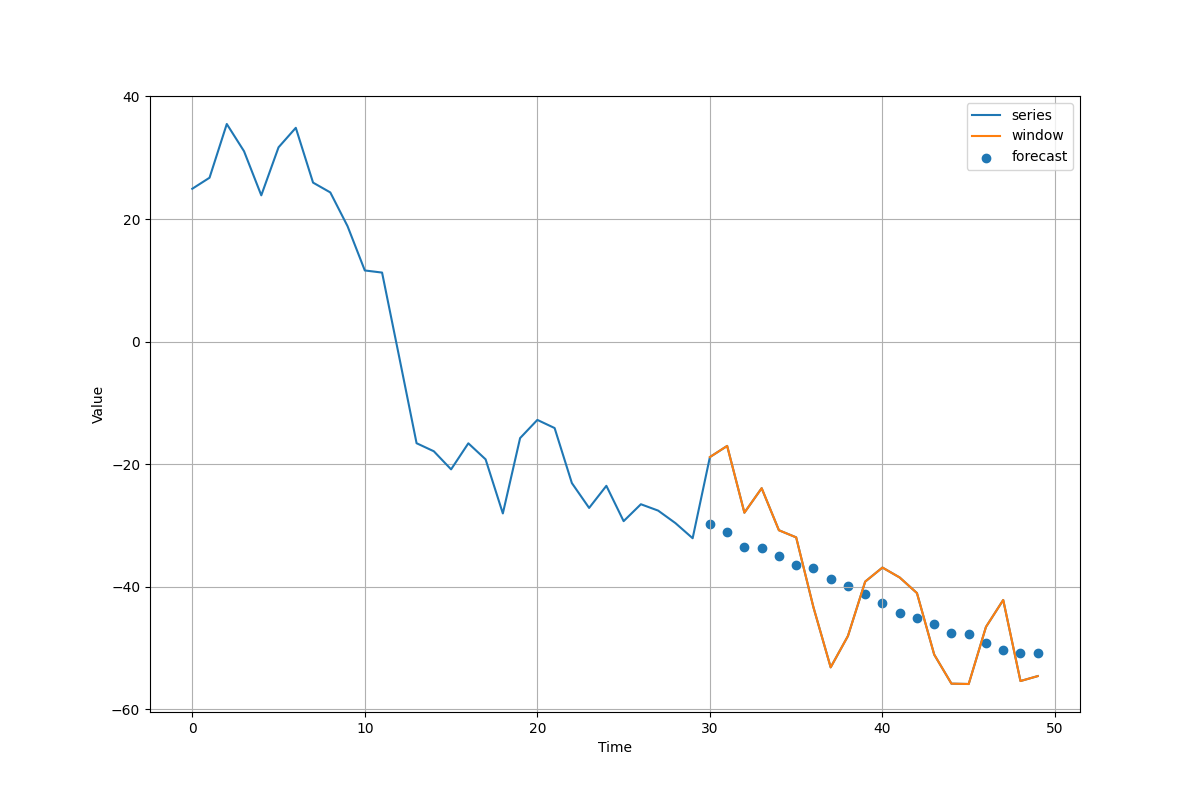

In [69]:
data_handler.plot_all(
    series_lines = [
        (time_data[0:window_size+nforecast], series[0:window_size+nforecast]),
        (time_data[window_size:window_size+nforecast], series[window_size:window_size+nforecast])
    ],
    series_points = [(time_data[window_size:window_size+nforecast], results[0]),],
    labels_lines = ["series", "window"],
    labels_points = ["forecast"],
    xy_label = ["Time", "Value"],
)


In [40]:
results[-2], results[-1]

(array([-921.6286 , -922.06055, -923.11835, -924.3282 , -924.42053,
        -925.5126 , -926.62976, -927.813  , -928.36957, -929.7471 ,
        -929.818  , -931.5019 , -931.9075 , -932.87415, -934.0895 ,
        -933.885  , -934.72815, -936.39526, -937.5441 , -938.8192 ],
       dtype=float32),
 array([-921.6286 , -922.06055, -923.11835, -924.32825, -924.4204 ,
        -925.5126 , -926.62976, -927.813  , -928.3695 , -929.7471 ,
        -929.818  , -931.5019 , -931.9075 , -932.8741 , -934.0895 ,
        -933.885  , -934.72815, -936.39526, -937.5441 , -938.8192 ],
       dtype=float32))

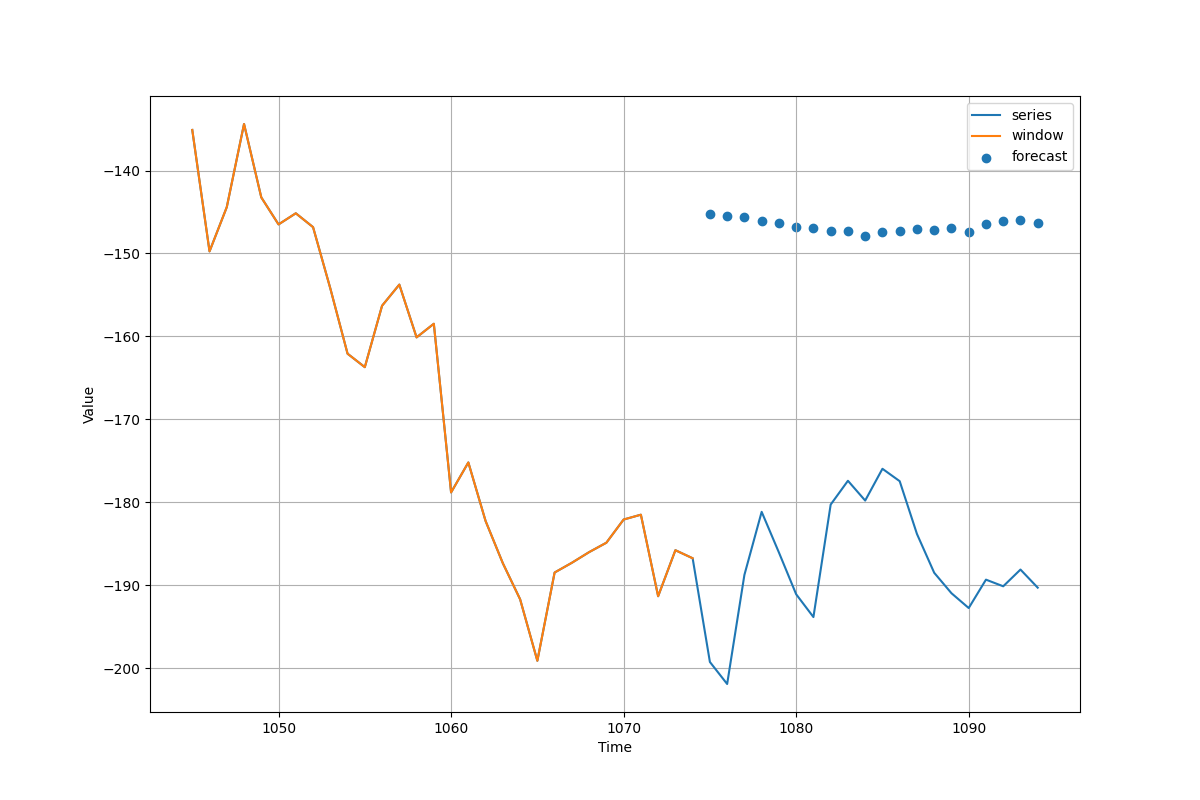

In [70]:
data_handler.plot_all(
    series_lines = [
        (time_data[-(window_size+nforecast):], series[-(window_size+nforecast):]),
        (time_data[-(window_size+nforecast):-nforecast], series[-(window_size+nforecast):-nforecast])
    ],
    series_points = [(time_data[-nforecast:], results[-1]),],
    labels_lines = ["series", "window"],
    labels_points = ["forecast"],
    xy_label = ["Time", "Value"],
)


In [23]:
from model_compra_comigo.data_handler import Visualizer

visualizer = Visualizer()

In [24]:
plots = visualizer.create_gif(
    time_data=time_data[:365],
    series=series[:365],
    forecast=results[:365],
    batch_size=batch_size,
    window_size=window_size,
    nforecast=nforecast,
    gif_window=70
)


In [25]:
plots[0].save('./tmp/k_nn.gif',
             save_all = True, append_images = plots[1:100], 
             optimize = False, duration = 100)

In [27]:
import gc
plots = None
gc.collect()

1488101

In [28]:
plots = visualizer.create_gif(
    time_data=time_data[-365:],
    series=series[-365:],
    forecast=results[-365:],
    batch_size=batch_size,
    window_size=window_size,
    nforecast=nforecast,
    gif_window=70
)

In [29]:
plots[0].save('./tmp/k_nn_end.gif',
             save_all = True, append_images = plots, 
             optimize = False, duration = 100)

In [ ]:
plots = None
gc.collect()

## Lessons
Most promising approach, will need to see how to automate the selection of these hyperparameters (and make it robust in an application)

In [16]:
import autokeras as ak
import numpy as np

predict_from = 1
predict_until = nforecast
lookback = window_size

clf = ak.TimeseriesForecaster(
    lookback=lookback,
#     predict_from=predict_from,
#     predict_until=predict_until,
    max_trials=1,
    objective="mse",
)
# Train the TimeSeriesForecaster with train data
clf.fit(
    x=np.array(inputs),
    y=np.array(targets),
#     validation_data=(inputs, targets),
#     batch_size=32,
    epochs=1000,
)
# Predict with the best model(includes original training data).
predictions = clf.predict(inputs)
print(predictions.shape)
# Evaluate the best model with testing data.
print(clf.evaluate(predictions, targets))

INFO:tensorflow:Reloading Tuner from ./time_series_forecaster/tuner0.json


{"levelname": "INFO", "asctime": "2023-07-13 01:21:51,447", "filename": "tuner.py", "funcName": "__init__", "lineno": 113, "message": "Reloading Tuner from ./time_series_forecaster/tuner0.json"}
2023-07-13 01:21:51.455703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [1017,20]
	 [[{{node Placeholder/_5}}]]
2023-07-13 01:21:51.455881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [1017,20]
	 [[{{node Placeholder/_5}}]]
2023-07-13 01:21:51.503109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Exe

INFO:tensorflow:Oracle triggered exit


2023-07-13 01:21:52.330895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 01:21:52.331712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 01:21:52.332298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/1000


2023-07-13 01:21:53.112950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 01:21:53.113714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 01:21:53.114289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 01:21:54.003697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 01:21:54.235814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 01:21:54.414018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ign

     31/Unknown - 3s 11ms/step - loss: 1249864.2500 - mean_squared_error: 1249864.2500

2023-07-13 01:21:56.186439: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [25,20] vs. [3,20]
	 [[{{node mean_squared_error/SquaredDifference}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ffreis/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/ffreis/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/ffreis/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ffreis/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/ffreis/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/ffreis/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ffreis/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ffreis/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ffreis/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2453486/2413807421.py", line 16, in <module>
      clf.fit(
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/tasks/time_series_forecaster.py", line 268, in fit
      super().fit(
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/tasks/time_series_forecaster.py", line 88, in fit
      history = super().fit(
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/tasks/structured_data.py", line 139, in fit
      history = super().fit(
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/auto_model.py", line 292, in fit
      history = self.tuner.search(
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/engine/tuner.py", line 220, in search
      pipeline, model, history = self.final_fit(**copied_fit_kwargs)
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/engine/tuner.py", line 270, in final_fit
      model, history = utils.fit_with_adaptive_batch_size(
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/utils/utils.py", line 88, in fit_with_adaptive_batch_size
      history = run_with_adaptive_batch_size(
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/utils/utils.py", line 101, in run_with_adaptive_batch_size
      history = func(x=x, validation_data=validation_data, **fit_kwargs)
    File "/home/ffreis/.local/lib/python3.8/site-packages/autokeras/utils/utils.py", line 89, in <lambda>
      batch_size, lambda **kwargs: model.fit(**kwargs), **fit_kwargs
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ffreis/.local/lib/python3.8/site-packages/keras/losses.py", line 1470, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
Incompatible shapes: [25,20] vs. [3,20]
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_train_function_16050]

In [ ]:
np.array(targets)

In [ ]:
import autokeras as ak
import numpy as np

def generate_time_series_forecaster(window_size, n_forecast):
    # Generate some dummy data
    X_train = np.random.rand(100, window_size, 1)
    y_train = np.random.rand(100, n_forecast, 1)
    
    # Initialize the time series regressor
    input_node = ak.Input()
    output_node = ak.TemporalConvBlock()(input_node)
    output_node = ak.RegressionHead()(output_node)
    regressor = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10)
    
    # Search for the best model architecture
    regressor.fit(X_train, y_train, epochs=10)
    
    return regressor

In [ ]:
def generate_time_series_forecaster(window_size, n_forecast):
    # Generate some dummy data
    X_train = np.random.rand(100, window_size, 1)
    y_train = np.random.rand(100, n_forecast, 1)
    
    # Initialize the time series regressor
    input_node = ak.Input()
    output_node = ak.TCNBlock()(input_node)
    output_node = ak.RegressionHead()(output_node)
    regressor = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10)
    
    # Search for the best model architecture
    regressor.fit(X_train, y_train, epochs=10)
    
    return regressor

In [ ]:
def generate_time_series_forecaster(window_size, n_forecast):
    # Generate some dummy data
    X_train = np.random.rand(100, window_size, 1)
    y_train = np.random.rand(100, n_forecast, 1)

    # Initialize the time series forecaster
    input_node = ak.Input()
    output_node = ak.TimeseriesForecaster(output_dim=n_forecast)(input_node)
    forecaster = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10)

    # Search for the best model architecture
    forecaster.fit(X_train, y_train, epochs=10)

    return forecaster

In [ ]:
!pip install autokeras --upgrade

In [ ]:
def generate_time_series_forecaster(window_size, n_forecast):
    # Generate some dummy data
    X_train = np.random.rand(100, window_size, 1)
    y_train = np.random.rand(100, n_forecast, 1)

    # Initialize the time series forecaster
    input_node = ak.Input()
    output_node = ak.TimeseriesForecaster(block_type='dense', output_dim=n_forecast)(input_node)
    forecaster = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10)

    # Search for the best model architecture
    forecaster.fit(X_train, y_train, epochs=10)

    return forecaster

In [ ]:
def generate_time_series_forecaster(window_size, n_forecast):
    # Generate some dummy data
    X_train = np.random.rand(100, window_size, 1)
    y_train = np.random.rand(100, n_forecast, 1)

    # Initialize the time series forecaster
    input_node = ak.Input()
    output_node = ak.AutoRegressor()(input_node)
    forecaster = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10)

    # Search for the best model architecture
    forecaster.fit(X_train, y_train, epochs=10)

    return forecaster

In [42]:
i = np.array(inputs)
i

array([[   46.38905809,    37.72480807,    61.36841567, ...,
          -59.55122336,   -53.17773076,     4.52852933],
       [  -69.79983062,   -10.49298299,   -25.06042815, ...,
          -48.28977641,   -66.98967473,   -57.45410727],
       [ -104.34262985,  -152.18642696,  -126.30070405, ...,
         -163.76274733,  -172.1042314 ,  -149.0348571 ],
       ...,
       [-1465.02020035, -1491.09848926, -1427.77907774, ...,
        -1504.29182392, -1521.07068844, -1504.03149251],
       [-1244.60983883, -1270.1261529 , -1240.48107783, ...,
        -1317.2535713 , -1307.15381528, -1313.97239863],
       [-1735.04961371, -1678.60077067, -1637.572154  , ...,
        -1748.89944507, -1770.95367832, -1784.05375528]])

In [43]:
np.reshape(
            i, (-1,window_size, 1)
        ),

(array([[[   46.38905809],
         [   37.72480807],
         [   61.36841567],
         ...,
         [  -59.55122336],
         [  -53.17773076],
         [    4.52852933]],
 
        [[  -69.79983062],
         [  -10.49298299],
         [  -25.06042815],
         ...,
         [  -48.28977641],
         [  -66.98967473],
         [  -57.45410727]],
 
        [[ -104.34262985],
         [ -152.18642696],
         [ -126.30070405],
         ...,
         [ -163.76274733],
         [ -172.1042314 ],
         [ -149.0348571 ]],
 
        ...,
 
        [[-1465.02020035],
         [-1491.09848926],
         [-1427.77907774],
         ...,
         [-1504.29182392],
         [-1521.07068844],
         [-1504.03149251]],
 
        [[-1244.60983883],
         [-1270.1261529 ],
         [-1240.48107783],
         ...,
         [-1317.2535713 ],
         [-1307.15381528],
         [-1313.97239863]],
 
        [[-1735.04961371],
         [-1678.60077067],
         [-1637.572154  ],
         

In [18]:
import autokeras as ak
import numpy as np

def generate_time_series_forecaster(window_size, n_forecast):
    # Generate some dummy data
    X_train = np.random.rand(1000, window_size, 1)
    y_train = np.random.rand(1000, n_forecast, 1)

    # Initialize the time series forecaster
    input_node = ak.Input()
    gru_node = ak.RNNBlock(return_sequences=True, layer_type="lstm")(input_node)
    output_node = ak.RegressionHead(output_dim=n_forecast)(gru_node)

    auto_model = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=5)

#     predict_from = 1
#     predict_until = n_forecast
#     lookback = window_size
#     auto_model = ak.TimeseriesForecaster(
#         lookback=lookback,
#         predict_from=predict_from,
#         predict_until=predict_until,
#         max_trials=1,
#         objective="mse",
#     )
    i = np.array(inputs)
    t = np.array(targets)
    print(t.shape)
    # Search for the best model architecture
    auto_model.fit(
        np.reshape(
            i, (-1,window_size, 1)
        ),
        np.reshape(
            t, (-1, n_forecast)
        ),
        batch_size=100,
        epochs=5000,
        validation_split=0.1)
    
    return auto_model

model = generate_time_series_forecaster(window_size, nforecast)

Trial 5 Complete [00h 14m 41s]
val_loss: 794593.75

Best val_loss So Far: 620760.5
Total elapsed time: 00h 47m 57s
INFO:tensorflow:Oracle triggered exit


{"levelname": "INFO", "asctime": "2023-07-13 02:11:03,539", "filename": "tuner.py", "funcName": "search", "lineno": 193, "message": "Oracle triggered exit"}
2023-07-13 02:11:03.990539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:11:03.991395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:11:03.991992: I tensorflow/core/common_runtime/execut

Epoch 1/5000


2023-07-13 02:11:04.412879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:11:04.413709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:11:04.414302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:11:05.082571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:11:05.083421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:11:05.084072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:11:06.638587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:11:06.639440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:11:06.640075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 4s 13ms/step - loss: 1439057.6250 - mean_squared_error: 1439057.6250
Epoch 2/5000
11/11 [==============================] - 0s 14ms/step - loss: 1438916.5000 - mean_squared_error: 1438916.5000
Epoch 3/5000
11/11 [==============================] - 0s 14ms/step - loss: 1438715.7500 - mean_squared_error: 1438715.7500
Epoch 4/5000
11/11 [==============================] - 0s 14ms/step - loss: 1438419.7500 - mean_squared_error: 1438419.7500
Epoch 5/5000
11/11 [==============================] - 0s 13ms/step - loss: 1438009.2500 - mean_squared_error: 1438009.2500
Epoch 6/5000
11/11 [==============================] - 0s 14ms/step - loss: 1437452.2500 - mean_squared_error: 1437452.2500
Epoch 7/5000
11/11 [==============================] - 0s 14ms/step - loss: 1436707.0000 - mean_squared_error: 1436707.0000
Epoch 8/5000
11/11 [==============================] - 0s 13ms/step - loss: 1435782.5000 - mean_squared_error: 1435782.5000
Epoch 9/5000
11/11 [=========

11/11 [==============================] - 0s 14ms/step - loss: 1254070.8750 - mean_squared_error: 1254070.8750
Epoch 133/5000
11/11 [==============================] - 0s 14ms/step - loss: 1251193.7500 - mean_squared_error: 1251193.7500
Epoch 134/5000
11/11 [==============================] - 0s 14ms/step - loss: 1250048.7500 - mean_squared_error: 1250048.7500
Epoch 135/5000
11/11 [==============================] - 0s 13ms/step - loss: 1249243.0000 - mean_squared_error: 1249243.0000
Epoch 136/5000
11/11 [==============================] - 0s 14ms/step - loss: 1248215.7500 - mean_squared_error: 1248215.7500
Epoch 137/5000
11/11 [==============================] - 0s 14ms/step - loss: 1246990.0000 - mean_squared_error: 1246990.0000
Epoch 138/5000
11/11 [==============================] - 0s 13ms/step - loss: 1247106.2500 - mean_squared_error: 1247106.2500
Epoch 139/5000
11/11 [==============================] - 0s 14ms/step - loss: 1241794.8750 - mean_squared_error: 1241794.8750
Epoch 140/5000


11/11 [==============================] - 0s 13ms/step - loss: 1115657.5000 - mean_squared_error: 1115657.5000
Epoch 263/5000
11/11 [==============================] - 0s 13ms/step - loss: 1113781.6250 - mean_squared_error: 1113781.6250
Epoch 264/5000
11/11 [==============================] - 0s 14ms/step - loss: 1113186.5000 - mean_squared_error: 1113186.5000
Epoch 265/5000
11/11 [==============================] - 0s 13ms/step - loss: 1110772.6250 - mean_squared_error: 1110772.6250
Epoch 266/5000
11/11 [==============================] - 0s 12ms/step - loss: 1111198.0000 - mean_squared_error: 1111198.0000
Epoch 267/5000
11/11 [==============================] - 0s 14ms/step - loss: 1109767.3750 - mean_squared_error: 1109767.3750
Epoch 268/5000
11/11 [==============================] - 0s 13ms/step - loss: 1110116.3750 - mean_squared_error: 1110116.3750
Epoch 269/5000
11/11 [==============================] - 0s 13ms/step - loss: 1105253.8750 - mean_squared_error: 1105253.8750
Epoch 270/5000


11/11 [==============================] - 0s 14ms/step - loss: 998527.6250 - mean_squared_error: 998527.6250
Epoch 393/5000
11/11 [==============================] - 0s 13ms/step - loss: 995831.0625 - mean_squared_error: 995831.0625
Epoch 394/5000
11/11 [==============================] - 0s 13ms/step - loss: 990754.0000 - mean_squared_error: 990754.0000
Epoch 395/5000
11/11 [==============================] - 0s 13ms/step - loss: 991082.3750 - mean_squared_error: 991082.3750
Epoch 396/5000
11/11 [==============================] - 0s 13ms/step - loss: 990165.0625 - mean_squared_error: 990165.0625
Epoch 397/5000
11/11 [==============================] - 0s 14ms/step - loss: 990383.6875 - mean_squared_error: 990383.6875
Epoch 398/5000
11/11 [==============================] - 0s 14ms/step - loss: 988391.0000 - mean_squared_error: 988391.0000
Epoch 399/5000
11/11 [==============================] - 0s 13ms/step - loss: 987558.3125 - mean_squared_error: 987558.3125
Epoch 400/5000
11/11 [=========

11/11 [==============================] - 0s 13ms/step - loss: 887213.5000 - mean_squared_error: 887213.5000
Epoch 525/5000
11/11 [==============================] - 0s 13ms/step - loss: 885195.3125 - mean_squared_error: 885195.3125
Epoch 526/5000
11/11 [==============================] - 0s 14ms/step - loss: 883752.2500 - mean_squared_error: 883752.2500
Epoch 527/5000
11/11 [==============================] - 0s 13ms/step - loss: 884751.9375 - mean_squared_error: 884751.9375
Epoch 528/5000
11/11 [==============================] - 0s 14ms/step - loss: 879893.1875 - mean_squared_error: 879893.1875
Epoch 529/5000
11/11 [==============================] - 0s 13ms/step - loss: 879427.4375 - mean_squared_error: 879427.4375
Epoch 530/5000
11/11 [==============================] - 0s 13ms/step - loss: 881485.0625 - mean_squared_error: 881485.0625
Epoch 531/5000
11/11 [==============================] - 0s 14ms/step - loss: 875677.5000 - mean_squared_error: 875677.4375
Epoch 532/5000
11/11 [=========

11/11 [==============================] - 0s 14ms/step - loss: 788198.6875 - mean_squared_error: 788198.6250
Epoch 657/5000
11/11 [==============================] - 0s 13ms/step - loss: 789586.9375 - mean_squared_error: 789586.9375
Epoch 658/5000
11/11 [==============================] - 0s 13ms/step - loss: 788519.9375 - mean_squared_error: 788519.9375
Epoch 659/5000
11/11 [==============================] - 0s 14ms/step - loss: 787173.3125 - mean_squared_error: 787173.3125
Epoch 660/5000
11/11 [==============================] - 0s 13ms/step - loss: 789027.6250 - mean_squared_error: 789027.5625
Epoch 661/5000
11/11 [==============================] - 0s 13ms/step - loss: 786475.3750 - mean_squared_error: 786475.3750
Epoch 662/5000
11/11 [==============================] - 0s 15ms/step - loss: 787016.5625 - mean_squared_error: 787016.5625
Epoch 663/5000
11/11 [==============================] - 0s 14ms/step - loss: 782452.6250 - mean_squared_error: 782452.6250
Epoch 664/5000
11/11 [=========

11/11 [==============================] - 0s 14ms/step - loss: 702767.3750 - mean_squared_error: 702767.3750
Epoch 789/5000
11/11 [==============================] - 0s 14ms/step - loss: 699239.0000 - mean_squared_error: 699239.0000
Epoch 790/5000
11/11 [==============================] - 0s 13ms/step - loss: 699451.1875 - mean_squared_error: 699451.1875
Epoch 791/5000
11/11 [==============================] - 0s 15ms/step - loss: 710288.3750 - mean_squared_error: 710288.3750
Epoch 792/5000
11/11 [==============================] - 0s 13ms/step - loss: 704353.9375 - mean_squared_error: 704353.9375
Epoch 793/5000
11/11 [==============================] - 0s 13ms/step - loss: 698279.2500 - mean_squared_error: 698279.2500
Epoch 794/5000
11/11 [==============================] - 0s 14ms/step - loss: 700702.1250 - mean_squared_error: 700702.1250
Epoch 795/5000
11/11 [==============================] - 0s 13ms/step - loss: 699587.6875 - mean_squared_error: 699587.6875
Epoch 796/5000
11/11 [=========

11/11 [==============================] - 0s 13ms/step - loss: 632785.0000 - mean_squared_error: 632785.0000
Epoch 921/5000
11/11 [==============================] - 0s 13ms/step - loss: 629537.3750 - mean_squared_error: 629537.3750
Epoch 922/5000
11/11 [==============================] - 0s 14ms/step - loss: 627435.2500 - mean_squared_error: 627435.2500
Epoch 923/5000
11/11 [==============================] - 0s 14ms/step - loss: 624213.6875 - mean_squared_error: 624213.6875
Epoch 924/5000
11/11 [==============================] - 0s 14ms/step - loss: 632199.5625 - mean_squared_error: 632199.5625
Epoch 925/5000
11/11 [==============================] - 0s 13ms/step - loss: 627678.8125 - mean_squared_error: 627678.8125
Epoch 926/5000
11/11 [==============================] - 0s 14ms/step - loss: 624659.2500 - mean_squared_error: 624659.2500
Epoch 927/5000
11/11 [==============================] - 0s 13ms/step - loss: 628803.1875 - mean_squared_error: 628803.1875
Epoch 928/5000
11/11 [=========

11/11 [==============================] - 0s 14ms/step - loss: 560620.0625 - mean_squared_error: 560620.0000
Epoch 1053/5000
11/11 [==============================] - 0s 13ms/step - loss: 559007.8125 - mean_squared_error: 559007.8125
Epoch 1054/5000
11/11 [==============================] - 0s 14ms/step - loss: 561944.4375 - mean_squared_error: 561944.4375
Epoch 1055/5000
11/11 [==============================] - 0s 14ms/step - loss: 563001.5625 - mean_squared_error: 563001.5625
Epoch 1056/5000
11/11 [==============================] - 0s 13ms/step - loss: 568649.3750 - mean_squared_error: 568649.3750
Epoch 1057/5000
11/11 [==============================] - 0s 14ms/step - loss: 562214.3125 - mean_squared_error: 562214.3125
Epoch 1058/5000
11/11 [==============================] - 0s 13ms/step - loss: 564752.2500 - mean_squared_error: 564752.2500
Epoch 1059/5000
11/11 [==============================] - 0s 13ms/step - loss: 559491.1875 - mean_squared_error: 559491.1875
Epoch 1060/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 506705.9062 - mean_squared_error: 506705.9062
Epoch 1185/5000
11/11 [==============================] - 0s 13ms/step - loss: 506599.9062 - mean_squared_error: 506599.9062
Epoch 1186/5000
11/11 [==============================] - 0s 12ms/step - loss: 509496.6562 - mean_squared_error: 509496.6562
Epoch 1187/5000
11/11 [==============================] - 0s 13ms/step - loss: 504773.5625 - mean_squared_error: 504773.5625
Epoch 1188/5000
11/11 [==============================] - 0s 14ms/step - loss: 504912.7500 - mean_squared_error: 504912.7500
Epoch 1189/5000
11/11 [==============================] - 0s 14ms/step - loss: 507980.2500 - mean_squared_error: 507980.2500
Epoch 1190/5000
11/11 [==============================] - 0s 13ms/step - loss: 511441.8750 - mean_squared_error: 511441.8750
Epoch 1191/5000
11/11 [==============================] - 0s 13ms/step - loss: 503126.3750 - mean_squared_error: 503126.3750
Epoch 1192/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 458556.6875 - mean_squared_error: 458556.6875
Epoch 1317/5000
11/11 [==============================] - 0s 13ms/step - loss: 462781.6250 - mean_squared_error: 462781.6250
Epoch 1318/5000
11/11 [==============================] - 0s 14ms/step - loss: 462630.6562 - mean_squared_error: 462630.6562
Epoch 1319/5000
11/11 [==============================] - 0s 14ms/step - loss: 465171.3125 - mean_squared_error: 465171.3125
Epoch 1320/5000
11/11 [==============================] - 0s 13ms/step - loss: 454613.0312 - mean_squared_error: 454613.0312
Epoch 1321/5000
11/11 [==============================] - 0s 14ms/step - loss: 460605.5312 - mean_squared_error: 460605.5312
Epoch 1322/5000
11/11 [==============================] - 0s 12ms/step - loss: 457673.3750 - mean_squared_error: 457673.3750
Epoch 1323/5000
11/11 [==============================] - 0s 15ms/step - loss: 455322.3125 - mean_squared_error: 455322.3125
Epoch 1324/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 428636.2188 - mean_squared_error: 428636.2188
Epoch 1449/5000
11/11 [==============================] - 0s 13ms/step - loss: 425542.7188 - mean_squared_error: 425542.7188
Epoch 1450/5000
11/11 [==============================] - 0s 14ms/step - loss: 422116.6562 - mean_squared_error: 422116.6562
Epoch 1451/5000
11/11 [==============================] - 0s 13ms/step - loss: 420592.1250 - mean_squared_error: 420592.1250
Epoch 1452/5000
11/11 [==============================] - 0s 13ms/step - loss: 420669.5625 - mean_squared_error: 420669.5938
Epoch 1453/5000
11/11 [==============================] - 0s 14ms/step - loss: 430741.2812 - mean_squared_error: 430741.2812
Epoch 1454/5000
11/11 [==============================] - 0s 13ms/step - loss: 417692.1875 - mean_squared_error: 417692.1875
Epoch 1455/5000
11/11 [==============================] - 0s 14ms/step - loss: 423026.7812 - mean_squared_error: 423026.7500
Epoch 1456/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 391788.5000 - mean_squared_error: 391788.5000
Epoch 1581/5000
11/11 [==============================] - 0s 15ms/step - loss: 387831.5312 - mean_squared_error: 387831.5312
Epoch 1582/5000
11/11 [==============================] - 0s 13ms/step - loss: 389783.1875 - mean_squared_error: 389783.1875
Epoch 1583/5000
11/11 [==============================] - 0s 13ms/step - loss: 379430.3125 - mean_squared_error: 379430.3125
Epoch 1584/5000
11/11 [==============================] - 0s 13ms/step - loss: 391721.0938 - mean_squared_error: 391721.0938
Epoch 1585/5000
11/11 [==============================] - 0s 14ms/step - loss: 390398.0000 - mean_squared_error: 390398.0000
Epoch 1586/5000
11/11 [==============================] - 0s 13ms/step - loss: 390108.0625 - mean_squared_error: 390108.0625
Epoch 1587/5000
11/11 [==============================] - 0s 12ms/step - loss: 379444.4688 - mean_squared_error: 379444.4688
Epoch 1588/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 362788.2188 - mean_squared_error: 362788.2188
Epoch 1713/5000
11/11 [==============================] - 0s 13ms/step - loss: 363845.7188 - mean_squared_error: 363845.7500
Epoch 1714/5000
11/11 [==============================] - 0s 14ms/step - loss: 371429.8125 - mean_squared_error: 371429.8125
Epoch 1715/5000
11/11 [==============================] - 0s 13ms/step - loss: 362865.6875 - mean_squared_error: 362865.6875
Epoch 1716/5000
11/11 [==============================] - 0s 14ms/step - loss: 364148.0938 - mean_squared_error: 364148.0938
Epoch 1717/5000
11/11 [==============================] - 0s 14ms/step - loss: 365839.7500 - mean_squared_error: 365839.7500
Epoch 1718/5000
11/11 [==============================] - 0s 13ms/step - loss: 370919.2188 - mean_squared_error: 370919.2188
Epoch 1719/5000
11/11 [==============================] - 0s 13ms/step - loss: 363478.6562 - mean_squared_error: 363478.6562
Epoch 1720/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 350447.7188 - mean_squared_error: 350447.7188
Epoch 1845/5000
11/11 [==============================] - 0s 13ms/step - loss: 349496.8750 - mean_squared_error: 349496.8750
Epoch 1846/5000
11/11 [==============================] - 0s 13ms/step - loss: 351771.2188 - mean_squared_error: 351771.2188
Epoch 1847/5000
11/11 [==============================] - 0s 13ms/step - loss: 350634.9062 - mean_squared_error: 350634.9062
Epoch 1848/5000
11/11 [==============================] - 0s 14ms/step - loss: 346042.6250 - mean_squared_error: 346042.6250
Epoch 1849/5000
11/11 [==============================] - 0s 13ms/step - loss: 339118.4375 - mean_squared_error: 339118.4375
Epoch 1850/5000
11/11 [==============================] - 0s 13ms/step - loss: 340772.5938 - mean_squared_error: 340772.5938
Epoch 1851/5000
11/11 [==============================] - 0s 13ms/step - loss: 344214.7812 - mean_squared_error: 344214.7812
Epoch 1852/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 631457.3750 - mean_squared_error: 631457.3750
Epoch 1977/5000
11/11 [==============================] - 0s 14ms/step - loss: 415403.3750 - mean_squared_error: 415403.3750
Epoch 1978/5000
11/11 [==============================] - 0s 14ms/step - loss: 377595.7188 - mean_squared_error: 377595.6875
Epoch 1979/5000
11/11 [==============================] - 0s 14ms/step - loss: 382881.1250 - mean_squared_error: 382881.1250
Epoch 1980/5000
11/11 [==============================] - 0s 13ms/step - loss: 383177.8125 - mean_squared_error: 383177.8438
Epoch 1981/5000
11/11 [==============================] - 0s 13ms/step - loss: 375830.2812 - mean_squared_error: 375830.2812
Epoch 1982/5000
11/11 [==============================] - 0s 14ms/step - loss: 387760.5312 - mean_squared_error: 387760.5312
Epoch 1983/5000
11/11 [==============================] - 0s 13ms/step - loss: 385792.9062 - mean_squared_error: 385792.9062
Epoch 1984/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 360219.3438 - mean_squared_error: 360219.3438
Epoch 2109/5000
11/11 [==============================] - 0s 15ms/step - loss: 364466.0938 - mean_squared_error: 364466.0938
Epoch 2110/5000
11/11 [==============================] - 0s 13ms/step - loss: 362283.8438 - mean_squared_error: 362283.8438
Epoch 2111/5000
11/11 [==============================] - 0s 14ms/step - loss: 367000.0625 - mean_squared_error: 367000.0625
Epoch 2112/5000
11/11 [==============================] - 0s 13ms/step - loss: 361793.7812 - mean_squared_error: 361793.7812
Epoch 2113/5000
11/11 [==============================] - 0s 13ms/step - loss: 357749.8750 - mean_squared_error: 357749.8750
Epoch 2114/5000
11/11 [==============================] - 0s 14ms/step - loss: 354590.6250 - mean_squared_error: 354590.6250
Epoch 2115/5000
11/11 [==============================] - 0s 13ms/step - loss: 365139.8750 - mean_squared_error: 365139.8750
Epoch 2116/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 353805.5625 - mean_squared_error: 353805.5625
Epoch 2241/5000
11/11 [==============================] - 0s 14ms/step - loss: 357086.4688 - mean_squared_error: 357086.4688
Epoch 2242/5000
11/11 [==============================] - 0s 13ms/step - loss: 354889.8750 - mean_squared_error: 354889.8750
Epoch 2243/5000
11/11 [==============================] - 0s 13ms/step - loss: 352821.7500 - mean_squared_error: 352821.7500
Epoch 2244/5000
11/11 [==============================] - 0s 13ms/step - loss: 353077.0312 - mean_squared_error: 353077.0000
Epoch 2245/5000
11/11 [==============================] - 0s 13ms/step - loss: 349624.7500 - mean_squared_error: 349624.7500
Epoch 2246/5000
11/11 [==============================] - 0s 14ms/step - loss: 348068.9688 - mean_squared_error: 348068.9688
Epoch 2247/5000
11/11 [==============================] - 0s 14ms/step - loss: 351806.3438 - mean_squared_error: 351806.3438
Epoch 2248/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 346840.8750 - mean_squared_error: 346840.8750
Epoch 2373/5000
11/11 [==============================] - 0s 14ms/step - loss: 343602.7188 - mean_squared_error: 343602.7188
Epoch 2374/5000
11/11 [==============================] - 0s 14ms/step - loss: 352301.7812 - mean_squared_error: 352301.7812
Epoch 2375/5000
11/11 [==============================] - 0s 13ms/step - loss: 346421.0625 - mean_squared_error: 346421.0938
Epoch 2376/5000
11/11 [==============================] - 0s 13ms/step - loss: 342949.2500 - mean_squared_error: 342949.2500
Epoch 2377/5000
11/11 [==============================] - 0s 13ms/step - loss: 346422.7188 - mean_squared_error: 346422.7188
Epoch 2378/5000
11/11 [==============================] - 0s 13ms/step - loss: 346033.8438 - mean_squared_error: 346033.8438
Epoch 2379/5000
11/11 [==============================] - 0s 13ms/step - loss: 348624.6562 - mean_squared_error: 348624.6562
Epoch 2380/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 348226.2188 - mean_squared_error: 348226.2188
Epoch 2505/5000
11/11 [==============================] - 0s 13ms/step - loss: 350919.9062 - mean_squared_error: 350919.9062
Epoch 2506/5000
11/11 [==============================] - 0s 14ms/step - loss: 342168.1250 - mean_squared_error: 342168.1250
Epoch 2507/5000
11/11 [==============================] - 0s 13ms/step - loss: 342087.4062 - mean_squared_error: 342087.4062
Epoch 2508/5000
11/11 [==============================] - 0s 14ms/step - loss: 348214.5312 - mean_squared_error: 348214.5312
Epoch 2509/5000
11/11 [==============================] - 0s 14ms/step - loss: 348602.1875 - mean_squared_error: 348602.2188
Epoch 2510/5000
11/11 [==============================] - 0s 14ms/step - loss: 347670.1250 - mean_squared_error: 347670.1250
Epoch 2511/5000
11/11 [==============================] - 0s 14ms/step - loss: 340642.9688 - mean_squared_error: 340642.9688
Epoch 2512/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 342756.1875 - mean_squared_error: 342756.1875
Epoch 2637/5000
11/11 [==============================] - 0s 13ms/step - loss: 350075.8750 - mean_squared_error: 350075.8750
Epoch 2638/5000
11/11 [==============================] - 0s 13ms/step - loss: 344442.6250 - mean_squared_error: 344442.6250
Epoch 2639/5000
11/11 [==============================] - 0s 14ms/step - loss: 341867.0000 - mean_squared_error: 341867.0000
Epoch 2640/5000
11/11 [==============================] - 0s 14ms/step - loss: 335546.9062 - mean_squared_error: 335546.9062
Epoch 2641/5000
11/11 [==============================] - 0s 12ms/step - loss: 352574.7188 - mean_squared_error: 352574.7188
Epoch 2642/5000
11/11 [==============================] - 0s 14ms/step - loss: 343503.8750 - mean_squared_error: 343503.8750
Epoch 2643/5000
11/11 [==============================] - 0s 13ms/step - loss: 351475.5000 - mean_squared_error: 351475.5000
Epoch 2644/5000
11/11 [=

11/11 [==============================] - 0s 12ms/step - loss: 345759.7812 - mean_squared_error: 345759.7812
Epoch 2769/5000
11/11 [==============================] - 0s 13ms/step - loss: 339208.0312 - mean_squared_error: 339208.0312
Epoch 2770/5000
11/11 [==============================] - 0s 13ms/step - loss: 345824.0000 - mean_squared_error: 345824.0000
Epoch 2771/5000
11/11 [==============================] - 0s 13ms/step - loss: 345630.8438 - mean_squared_error: 345630.8438
Epoch 2772/5000
11/11 [==============================] - 0s 14ms/step - loss: 336201.0938 - mean_squared_error: 336201.0938
Epoch 2773/5000
11/11 [==============================] - 0s 13ms/step - loss: 333760.9688 - mean_squared_error: 333760.9688
Epoch 2774/5000
11/11 [==============================] - 0s 13ms/step - loss: 345959.1562 - mean_squared_error: 345959.1562
Epoch 2775/5000
11/11 [==============================] - 0s 14ms/step - loss: 351210.0312 - mean_squared_error: 351210.0312
Epoch 2776/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 338057.7812 - mean_squared_error: 338057.7812
Epoch 2901/5000
11/11 [==============================] - 0s 13ms/step - loss: 338966.6875 - mean_squared_error: 338966.6875
Epoch 2902/5000
11/11 [==============================] - 0s 13ms/step - loss: 340594.8125 - mean_squared_error: 340594.8125
Epoch 2903/5000
11/11 [==============================] - 0s 14ms/step - loss: 333944.4062 - mean_squared_error: 333944.4062
Epoch 2904/5000
11/11 [==============================] - 0s 13ms/step - loss: 342260.8750 - mean_squared_error: 342260.9062
Epoch 2905/5000
11/11 [==============================] - 0s 14ms/step - loss: 341881.3125 - mean_squared_error: 341881.3125
Epoch 2906/5000
11/11 [==============================] - 0s 14ms/step - loss: 343431.2812 - mean_squared_error: 343431.2812
Epoch 2907/5000
11/11 [==============================] - 0s 13ms/step - loss: 345799.8750 - mean_squared_error: 345799.8750
Epoch 2908/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 340605.7500 - mean_squared_error: 340605.7500
Epoch 3033/5000
11/11 [==============================] - 0s 13ms/step - loss: 347664.6875 - mean_squared_error: 347664.6875
Epoch 3034/5000
11/11 [==============================] - 0s 13ms/step - loss: 340307.3750 - mean_squared_error: 340307.3750
Epoch 3035/5000
11/11 [==============================] - 0s 13ms/step - loss: 339876.8750 - mean_squared_error: 339876.8750
Epoch 3036/5000
11/11 [==============================] - 0s 14ms/step - loss: 347129.9688 - mean_squared_error: 347129.9688
Epoch 3037/5000
11/11 [==============================] - 0s 14ms/step - loss: 343547.7812 - mean_squared_error: 343547.7812
Epoch 3038/5000
11/11 [==============================] - 0s 13ms/step - loss: 338226.4688 - mean_squared_error: 338226.4688
Epoch 3039/5000
11/11 [==============================] - 0s 13ms/step - loss: 332768.2500 - mean_squared_error: 332768.2500
Epoch 3040/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 349231.0625 - mean_squared_error: 349231.0625
Epoch 3165/5000
11/11 [==============================] - 0s 13ms/step - loss: 340370.7188 - mean_squared_error: 340370.6875
Epoch 3166/5000
11/11 [==============================] - 0s 14ms/step - loss: 340248.8125 - mean_squared_error: 340248.8125
Epoch 3167/5000
11/11 [==============================] - 0s 14ms/step - loss: 337428.2188 - mean_squared_error: 337428.2188
Epoch 3168/5000
11/11 [==============================] - 0s 13ms/step - loss: 352714.5938 - mean_squared_error: 352714.5938
Epoch 3169/5000
11/11 [==============================] - 0s 13ms/step - loss: 345049.9688 - mean_squared_error: 345049.9688
Epoch 3170/5000
11/11 [==============================] - 0s 13ms/step - loss: 339987.0625 - mean_squared_error: 339987.0625
Epoch 3171/5000
11/11 [==============================] - 0s 13ms/step - loss: 342744.2188 - mean_squared_error: 342744.2188
Epoch 3172/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 339993.5938 - mean_squared_error: 339993.5938
Epoch 3297/5000
11/11 [==============================] - 0s 13ms/step - loss: 338202.8750 - mean_squared_error: 338202.8750
Epoch 3298/5000
11/11 [==============================] - 0s 14ms/step - loss: 337190.8750 - mean_squared_error: 337190.8750
Epoch 3299/5000
11/11 [==============================] - 0s 14ms/step - loss: 348481.3750 - mean_squared_error: 348481.3750
Epoch 3300/5000
11/11 [==============================] - 0s 13ms/step - loss: 341894.9375 - mean_squared_error: 341894.9375
Epoch 3301/5000
11/11 [==============================] - 0s 14ms/step - loss: 341399.9375 - mean_squared_error: 341399.9375
Epoch 3302/5000
11/11 [==============================] - 0s 14ms/step - loss: 340820.6250 - mean_squared_error: 340820.6250
Epoch 3303/5000
11/11 [==============================] - 0s 13ms/step - loss: 341257.0625 - mean_squared_error: 341257.0625
Epoch 3304/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 347634.3438 - mean_squared_error: 347634.3438
Epoch 3429/5000
11/11 [==============================] - 0s 14ms/step - loss: 336424.8125 - mean_squared_error: 336424.8125
Epoch 3430/5000
11/11 [==============================] - 0s 13ms/step - loss: 340110.2500 - mean_squared_error: 340110.2500
Epoch 3431/5000
11/11 [==============================] - 0s 14ms/step - loss: 338951.0938 - mean_squared_error: 338951.0938
Epoch 3432/5000
11/11 [==============================] - 0s 14ms/step - loss: 336288.9062 - mean_squared_error: 336288.9062
Epoch 3433/5000
11/11 [==============================] - 0s 12ms/step - loss: 336694.1562 - mean_squared_error: 336694.1562
Epoch 3434/5000
11/11 [==============================] - 0s 14ms/step - loss: 343411.5938 - mean_squared_error: 343411.5938
Epoch 3435/5000
11/11 [==============================] - 0s 14ms/step - loss: 339537.5938 - mean_squared_error: 339537.5938
Epoch 3436/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 318466.1562 - mean_squared_error: 318466.1562
Epoch 3561/5000
11/11 [==============================] - 0s 14ms/step - loss: 324513.5000 - mean_squared_error: 324513.5000
Epoch 3562/5000
11/11 [==============================] - 0s 14ms/step - loss: 318756.9062 - mean_squared_error: 318756.9062
Epoch 3563/5000
11/11 [==============================] - 0s 14ms/step - loss: 319295.8125 - mean_squared_error: 319295.8125
Epoch 3564/5000
11/11 [==============================] - 0s 13ms/step - loss: 316136.2500 - mean_squared_error: 316136.2500
Epoch 3565/5000
11/11 [==============================] - 0s 13ms/step - loss: 318718.8438 - mean_squared_error: 318718.8438
Epoch 3566/5000
11/11 [==============================] - 0s 13ms/step - loss: 317037.7812 - mean_squared_error: 317037.7812
Epoch 3567/5000
11/11 [==============================] - 0s 14ms/step - loss: 316612.8438 - mean_squared_error: 316612.8438
Epoch 3568/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 298835.8125 - mean_squared_error: 298835.8125
Epoch 3693/5000
11/11 [==============================] - 0s 13ms/step - loss: 291227.4062 - mean_squared_error: 291227.4062
Epoch 3694/5000
11/11 [==============================] - 0s 14ms/step - loss: 293806.5625 - mean_squared_error: 293806.5625
Epoch 3695/5000
11/11 [==============================] - 0s 13ms/step - loss: 294567.6875 - mean_squared_error: 294567.6875
Epoch 3696/5000
11/11 [==============================] - 0s 13ms/step - loss: 299503.1250 - mean_squared_error: 299503.1250
Epoch 3697/5000
11/11 [==============================] - 0s 14ms/step - loss: 289500.3125 - mean_squared_error: 289500.3125
Epoch 3698/5000
11/11 [==============================] - 0s 13ms/step - loss: 296117.8438 - mean_squared_error: 296117.7812
Epoch 3699/5000
11/11 [==============================] - 0s 14ms/step - loss: 292724.2500 - mean_squared_error: 292724.2500
Epoch 3700/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 292668.1562 - mean_squared_error: 292668.1562
Epoch 3825/5000
11/11 [==============================] - 0s 14ms/step - loss: 292293.1562 - mean_squared_error: 292293.1562
Epoch 3826/5000
11/11 [==============================] - 0s 14ms/step - loss: 289841.3438 - mean_squared_error: 289841.3125
Epoch 3827/5000
11/11 [==============================] - 0s 13ms/step - loss: 285466.6562 - mean_squared_error: 285466.6562
Epoch 3828/5000
11/11 [==============================] - 0s 13ms/step - loss: 295551.0938 - mean_squared_error: 295551.1562
Epoch 3829/5000
11/11 [==============================] - 0s 14ms/step - loss: 304944.9688 - mean_squared_error: 304944.9688
Epoch 3830/5000
11/11 [==============================] - 0s 14ms/step - loss: 285526.6250 - mean_squared_error: 285526.6250
Epoch 3831/5000
11/11 [==============================] - 0s 13ms/step - loss: 297758.6875 - mean_squared_error: 297758.6875
Epoch 3832/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 296843.6562 - mean_squared_error: 296843.6562
Epoch 3957/5000
11/11 [==============================] - 0s 13ms/step - loss: 297285.0938 - mean_squared_error: 297285.0938
Epoch 3958/5000
11/11 [==============================] - 0s 14ms/step - loss: 304095.2500 - mean_squared_error: 304095.2500
Epoch 3959/5000
11/11 [==============================] - 0s 13ms/step - loss: 305005.0625 - mean_squared_error: 305005.0625
Epoch 3960/5000
11/11 [==============================] - 0s 14ms/step - loss: 296652.3438 - mean_squared_error: 296652.3438
Epoch 3961/5000
11/11 [==============================] - 0s 14ms/step - loss: 299933.9062 - mean_squared_error: 299933.9062
Epoch 3962/5000
11/11 [==============================] - 0s 13ms/step - loss: 299810.9688 - mean_squared_error: 299810.9688
Epoch 3963/5000
11/11 [==============================] - 0s 13ms/step - loss: 300009.6875 - mean_squared_error: 300009.6875
Epoch 3964/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 300380.3125 - mean_squared_error: 300380.3125
Epoch 4089/5000
11/11 [==============================] - 0s 14ms/step - loss: 294535.7812 - mean_squared_error: 294535.7812
Epoch 4090/5000
11/11 [==============================] - 0s 14ms/step - loss: 293103.1875 - mean_squared_error: 293103.1875
Epoch 4091/5000
11/11 [==============================] - 0s 13ms/step - loss: 291807.7188 - mean_squared_error: 291807.7188
Epoch 4092/5000
11/11 [==============================] - 0s 12ms/step - loss: 298988.4062 - mean_squared_error: 298988.4062
Epoch 4093/5000
11/11 [==============================] - 0s 13ms/step - loss: 301376.2500 - mean_squared_error: 301376.2500
Epoch 4094/5000
11/11 [==============================] - 0s 14ms/step - loss: 300306.5938 - mean_squared_error: 300306.5938
Epoch 4095/5000
11/11 [==============================] - 0s 14ms/step - loss: 292277.6875 - mean_squared_error: 292277.6875
Epoch 4096/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 290585.0000 - mean_squared_error: 290585.0312
Epoch 4221/5000
11/11 [==============================] - 0s 14ms/step - loss: 290699.3750 - mean_squared_error: 290699.3750
Epoch 4222/5000
11/11 [==============================] - 0s 14ms/step - loss: 291199.9688 - mean_squared_error: 291199.9375
Epoch 4223/5000
11/11 [==============================] - 0s 14ms/step - loss: 299238.8750 - mean_squared_error: 299238.8750
Epoch 4224/5000
11/11 [==============================] - 0s 14ms/step - loss: 293623.4375 - mean_squared_error: 293623.4375
Epoch 4225/5000
11/11 [==============================] - 0s 13ms/step - loss: 298198.1875 - mean_squared_error: 298198.1875
Epoch 4226/5000
11/11 [==============================] - 0s 13ms/step - loss: 292143.3750 - mean_squared_error: 292143.3750
Epoch 4227/5000
11/11 [==============================] - 0s 13ms/step - loss: 302639.1875 - mean_squared_error: 302639.1875
Epoch 4228/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 298610.5312 - mean_squared_error: 298610.5312
Epoch 4353/5000
11/11 [==============================] - 0s 13ms/step - loss: 299635.8750 - mean_squared_error: 299635.8750
Epoch 4354/5000
11/11 [==============================] - 0s 13ms/step - loss: 297768.5625 - mean_squared_error: 297768.5625
Epoch 4355/5000
11/11 [==============================] - 0s 14ms/step - loss: 286325.4375 - mean_squared_error: 286325.4375
Epoch 4356/5000
11/11 [==============================] - 0s 14ms/step - loss: 309150.1875 - mean_squared_error: 309150.1875
Epoch 4357/5000
11/11 [==============================] - 0s 13ms/step - loss: 295747.5000 - mean_squared_error: 295747.5000
Epoch 4358/5000
11/11 [==============================] - 0s 14ms/step - loss: 292477.0312 - mean_squared_error: 292477.0312
Epoch 4359/5000
11/11 [==============================] - 0s 14ms/step - loss: 288869.8438 - mean_squared_error: 288869.8438
Epoch 4360/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 299689.0938 - mean_squared_error: 299689.0938
Epoch 4485/5000
11/11 [==============================] - 0s 13ms/step - loss: 290781.1562 - mean_squared_error: 290781.1875
Epoch 4486/5000
11/11 [==============================] - 0s 13ms/step - loss: 298611.5000 - mean_squared_error: 298611.5000
Epoch 4487/5000
11/11 [==============================] - 0s 13ms/step - loss: 286390.4062 - mean_squared_error: 286390.4062
Epoch 4488/5000
11/11 [==============================] - 0s 13ms/step - loss: 299360.8125 - mean_squared_error: 299360.8125
Epoch 4489/5000
11/11 [==============================] - 0s 14ms/step - loss: 287553.0938 - mean_squared_error: 287553.0938
Epoch 4490/5000
11/11 [==============================] - 0s 13ms/step - loss: 296782.7500 - mean_squared_error: 296782.7500
Epoch 4491/5000
11/11 [==============================] - 0s 14ms/step - loss: 293800.1875 - mean_squared_error: 293800.1875
Epoch 4492/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 298064.4688 - mean_squared_error: 298064.4688
Epoch 4617/5000
11/11 [==============================] - 0s 13ms/step - loss: 298661.6250 - mean_squared_error: 298661.6875
Epoch 4618/5000
11/11 [==============================] - 0s 12ms/step - loss: 294171.8125 - mean_squared_error: 294171.8125
Epoch 4619/5000
11/11 [==============================] - 0s 14ms/step - loss: 292427.1250 - mean_squared_error: 292427.1250
Epoch 4620/5000
11/11 [==============================] - 0s 14ms/step - loss: 303092.0000 - mean_squared_error: 303092.0000
Epoch 4621/5000
11/11 [==============================] - 0s 14ms/step - loss: 306084.6250 - mean_squared_error: 306084.5938
Epoch 4622/5000
11/11 [==============================] - 0s 15ms/step - loss: 300118.2500 - mean_squared_error: 300118.2500
Epoch 4623/5000
11/11 [==============================] - 0s 13ms/step - loss: 297645.2500 - mean_squared_error: 297645.2188
Epoch 4624/5000
11/11 [=

11/11 [==============================] - 0s 14ms/step - loss: 298153.2500 - mean_squared_error: 298153.2812
Epoch 4749/5000
11/11 [==============================] - 0s 14ms/step - loss: 299323.7812 - mean_squared_error: 299323.7812
Epoch 4750/5000
11/11 [==============================] - 0s 12ms/step - loss: 296236.9375 - mean_squared_error: 296236.9062
Epoch 4751/5000
11/11 [==============================] - 0s 13ms/step - loss: 294764.5625 - mean_squared_error: 294764.5625
Epoch 4752/5000
11/11 [==============================] - 0s 12ms/step - loss: 292917.8750 - mean_squared_error: 292917.8750
Epoch 4753/5000
11/11 [==============================] - 0s 13ms/step - loss: 298746.1875 - mean_squared_error: 298746.1875
Epoch 4754/5000
11/11 [==============================] - 0s 13ms/step - loss: 291740.9375 - mean_squared_error: 291740.9375
Epoch 4755/5000
11/11 [==============================] - 0s 14ms/step - loss: 302401.5312 - mean_squared_error: 302401.5312
Epoch 4756/5000
11/11 [=

11/11 [==============================] - 0s 13ms/step - loss: 289601.9062 - mean_squared_error: 289601.9375
Epoch 4881/5000
11/11 [==============================] - 0s 13ms/step - loss: 298650.0000 - mean_squared_error: 298650.0000
Epoch 4882/5000
11/11 [==============================] - 0s 13ms/step - loss: 296169.2500 - mean_squared_error: 296169.2500
Epoch 4883/5000
11/11 [==============================] - 0s 13ms/step - loss: 301180.0000 - mean_squared_error: 301180.0000
Epoch 4884/5000
11/11 [==============================] - 0s 13ms/step - loss: 294901.4688 - mean_squared_error: 294901.5000
Epoch 4885/5000
11/11 [==============================] - 0s 13ms/step - loss: 298293.7188 - mean_squared_error: 298293.7188
Epoch 4886/5000
11/11 [==============================] - 0s 13ms/step - loss: 306101.5938 - mean_squared_error: 306101.5938
Epoch 4887/5000
11/11 [==============================] - 0s 14ms/step - loss: 290757.1875 - mean_squared_error: 290757.2188
Epoch 4888/5000
11/11 [=

2023-07-13 02:24:07.807385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:07.808179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:07.808760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:08.500215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:08.500990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:08.501569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:09.400949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:09.401778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:09.402367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:09.866347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:09.867128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:09.867728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:10.522967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:10.523783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:10.524368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:11.167608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:11.168413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:11.169003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:11.840897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:11.841719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:11.842324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:12.475231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:12.476039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:12.476641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:13.201804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 02:24:13.226864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:13.227514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 02:24:14.121101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 02:24:14.146675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:14.147337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 02:24:14.777886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 02:24:14.804621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:14.805244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 02:24:15.428274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 02:24:15.453247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:15.453871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 02:24:16.064686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:16.065454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:16.066033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:16.693757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 02:24:16.718837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:16.719521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 02:24:17.379711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:17.380488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:17.381070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:18.045447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:18.046249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:18.046830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:18.676821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:18.677577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 02:24:18.678164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 02:24:19.304815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 02:24:19.330745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 02:24:19.331411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


{"levelname": "INFO", "asctime": "2023-07-13 02:24:21,822", "filename": "builder_impl.py", "funcName": "copy_assets_to_destination_dir", "lineno": 797, "message": "Assets written to: ./auto_model/best_model/assets"}


array([[-1929.53999594, -1961.00165263, -1964.55767678, ...,
        -1909.56735679, -1923.05987094, -1945.47483065],
       [-1961.00165263, -1964.55767678, -1938.41116982, ...,
        -1923.05987094, -1945.47483065, -1953.70679393],
       [-1964.55767678, -1938.41116982, -1931.05581382, ...,
        -1945.47483065, -1953.70679393, -1946.12153939],
       ...,
       [-1914.81785501, -1900.09768338, -1885.83581128, ...,
        -1931.09257791, -1932.78210875, -1966.10799588],
       [-1900.09768338, -1885.83581128, -1923.88924745, ...,
        -1932.78210875, -1966.10799588, -1955.35799465],
       [-1885.83581128, -1923.88924745, -1906.7273003 , ...,
        -1966.10799588, -1955.35799465, -1954.38104772]])

In [29]:
pre2 = model.predict(
    np.reshape(
        i[-50:], (-1,window_size, 1)
    ),
)

2023-07-13 11:49:08.105213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:08.105297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:08.105348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:08.328566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-07-13 11:49:08.329354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:08.329405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 11:49:08.554496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-07-13 11:49:08.555304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:08.555357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 11:49:08.763612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:08.763673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:08.763723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:09.249254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:09.249327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:09.249375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:09.457401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:09.457475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:09.457526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:09.916427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:09.916501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:09.916550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:10.233695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:10.233769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:10.233817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:10.724033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:10.724101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:10.724149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:11.157220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-07-13 11:49:11.157967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:11.158017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 11:49:11.675019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:49:11.675091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:49:11.675138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:12.602232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 11:49:12.603062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 11:49:12.603640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:49:13.308535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 11:49:13.309361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 11:49:13.309948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 3ms/step


In [30]:
pre2

array([[-1101.9879, -1103.6895, -1105.4188, -1107.0454, -1108.6769,
        -1110.4159, -1112.1609, -1113.8024, -1115.4578, -1117.1394,
        -1118.8563, -1120.5853, -1122.4059, -1124.2351, -1126.0712,
        -1127.8593, -1129.7363, -1131.5598, -1133.3997, -1135.3241],
       [-1101.9879, -1103.6895, -1105.4188, -1107.0454, -1108.6769,
        -1110.4159, -1112.1609, -1113.8024, -1115.4578, -1117.1394,
        -1118.8563, -1120.5853, -1122.4059, -1124.2351, -1126.0712,
        -1127.8593, -1129.7363, -1131.5598, -1133.3997, -1135.3241],
       [-1101.9879, -1103.6895, -1105.4188, -1107.0454, -1108.6769,
        -1110.4159, -1112.1609, -1113.8024, -1115.4578, -1117.1394,
        -1118.8563, -1120.5853, -1122.4059, -1124.2351, -1126.0712,
        -1127.8593, -1129.7363, -1131.5598, -1133.3997, -1135.3241],
       [-1101.9879, -1103.6895, -1105.4188, -1107.0454, -1108.6769,
        -1110.4159, -1112.1609, -1113.8024, -1115.4578, -1117.1394,
        -1118.8563, -1120.5853, -1122.4059, -

In [26]:
np.reshape(
        i, (-1,window_size, 1)
    ),

(array([[[  -20.98471561],
         [  -12.10540982],
         [   19.59098825],
         ...,
         [   18.99116149],
         [   13.16378675],
         [   10.50707193]],
 
        [[  -12.10540982],
         [   19.59098825],
         [   11.19709376],
         ...,
         [   13.16378675],
         [   10.50707193],
         [   49.66238216]],
 
        [[   19.59098825],
         [   11.19709376],
         [  -10.20481069],
         ...,
         [   10.50707193],
         [   49.66238216],
         [   59.29808998]],
 
        ...,
 
        [[-1914.81785501],
         [-1900.09768338],
         [-1885.83581128],
         ...,
         [-1931.09257791],
         [-1932.78210875],
         [-1966.10799588]],
 
        [[-1900.09768338],
         [-1885.83581128],
         [-1923.88924745],
         ...,
         [-1932.78210875],
         [-1966.10799588],
         [-1955.35799465]],
 
        [[-1885.83581128],
         [-1923.88924745],
         [-1906.7273003 ],
         

In [20]:
i = np.array(inputs)
pre = model.predict(
    np.reshape(
        i, (-1,window_size, 1)
    ),
)
pre

2023-07-13 11:41:24.844580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:24.844662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:24.844712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:25.069113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-07-13 11:41:25.069900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:25.069954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 11:41:25.305358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-07-13 11:41:25.306148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:25.306201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 11:41:25.521306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:25.521380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:25.521431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:25.758721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:25.758804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:25.758856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:26.203611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:26.203690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:26.203740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:26.623907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:26.623979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:26.624029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:26.843103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:26.843225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:26.843314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:27.318496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:27.318575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:27.318625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:27.519751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-07-13 11:41:27.520589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:27.520647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 11:41:28.944443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_reversev2_grad_reversev2_reversev2_axis' with dtype int32 and shape [1]
	 [[{{node gradients_reversev2_grad_reversev2_reversev2_axis}}]]
2023-07-13 11:41:28.945244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:28.945295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

2023-07-13 11:41:29.168073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:29.168151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:29.168201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:29.622522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-13 11:41:29.622595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-13 11:41:29.622643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:30.585588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 11:41:30.586454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 11:41:30.587039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-07-13 11:41:31.296413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 11:41:31.297266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 11:41:31.297868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 0s 3ms/step


array([[  -19.882252,   -19.408764,   -19.544458, ...,   -21.68626 ,
          -21.57542 ,   -21.454838],
       [   -8.788613,    -8.169158,    -8.277711, ...,   -10.239681,
          -10.036526,    -9.943562],
       [  -26.897713,   -26.462757,   -26.327469, ...,   -28.92686 ,
          -28.935604,   -28.633213],
       ...,
       [-1101.9879  , -1103.6895  , -1105.4188  , ..., -1131.5598  ,
        -1133.3997  , -1135.3241  ],
       [-1101.9879  , -1103.6895  , -1105.4188  , ..., -1131.5598  ,
        -1133.3997  , -1135.3241  ],
       [-1101.9879  , -1103.6895  , -1105.4188  , ..., -1131.5598  ,
        -1133.3997  , -1135.3241  ]], dtype=float32)

In [ ]:
mo = model.export_model()
mo.summary()

In [29]:
model = None

In [30]:
import gc
gc.collect()


542971

In [ ]:
pre = model.predict(
    np.reshape(
        i, (-1,window_size, 1)
    ),
)

In [37]:
pre = mo.predict(np.array(inputs))

2023-07-13 00:15:18.783736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 00:15:18.784576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-13 00:15:18.785171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


 1/33 [..............................] - ETA: 17s

2023-07-13 00:15:19.056305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-07-13 00:15:19.081474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-13 00:15:19.082124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

33/33 [==============================] - 1s 2ms/step


In [40]:
pre[:50]

array([[-906.8989 , -908.65155, -910.44916, -911.9363 , -914.39825,
        -915.4458 , -917.4047 , -918.9587 , -920.32935, -921.9673 ,
        -923.6033 , -925.5238 , -926.88196, -928.7788 , -930.6477 ,
        -932.17084, -933.57294, -935.4267 , -937.32684, -938.68054],
       [-906.8989 , -908.65155, -910.44916, -911.9363 , -914.39825,
        -915.4458 , -917.4047 , -918.9587 , -920.32935, -921.9673 ,
        -923.6033 , -925.5238 , -926.88196, -928.7788 , -930.6477 ,
        -932.17084, -933.57294, -935.4267 , -937.32684, -938.68054],
       [-906.8989 , -908.65155, -910.44916, -911.9363 , -914.39825,
        -915.4458 , -917.4047 , -918.9587 , -920.32935, -921.9673 ,
        -923.6033 , -925.5238 , -926.88196, -928.7788 , -930.6477 ,
        -932.17084, -933.57294, -935.4267 , -937.32684, -938.68054],
       [-906.8989 , -908.65155, -910.44916, -911.9363 , -914.39825,
        -915.4458 , -917.4047 , -918.9587 , -920.32935, -921.9673 ,
        -923.6033 , -925.5238 , -926.88196, -

In [17]:
import autokeras as ak
import numpy as np

def generate_time_series_forecaster(window_size, n_forecast):
    # Generate some dummy data
    X_train = np.random.rand(1000, window_size, 1)
    y_train = np.random.rand(1000, n_forecast, 1)

    # Initialize the time series forecaster
    input_node = ak.Input()
    gru_node = ak.RNNBlock(return_sequences=True, layer_type="lstm")(input_node)
    dense_node = ak.DenseBlock()(gru_node)
    output_node = ak.RegressionHead(output_dim=n_forecast)(dense_node)

    auto_model = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=2)

#     predict_from = 1
#     predict_until = n_forecast
#     lookback = window_size
#     auto_model = ak.TimeseriesForecaster(
#         lookback=lookback,
#         predict_from=predict_from,
#         predict_until=predict_until,
#         max_trials=1,
#         objective="mse",
#     )
    
    print(X_train.shape)
    print(y_train.shape)
    inputs
    # Search for the best model architecture
    auto_model.fit(
        np.reshape(
            np.array(inputs), (-1,window_size)
        ),
        np.reshape(
            np.array(targets), (-1,n_forecast, 1)
        ), batch_size=100, epochs=1, validation_split=0.1)
    
    return auto_model

In [ ]:
inputs

In [ ]:
np.reshape(
    inputs, (-1,window_size, 1)
),


In [ ]:
y = np.reshape(
    np.array(targets), (-1,nforecast,1)
)
y.shape

In [ ]:
X = np.reshape(
            np.array(inputs), (-1,window_size,1)
        )
X.shape

In [17]:
model = generate_time_series_forecaster(window_size, nforecast)

(1000, 30, 1)
(1000, 20, 1)


2023-07-12 23:21:40.446095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [1046,20,1]
	 [[{{node Placeholder/_5}}]]
2023-07-12 23:21:40.446218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [1046,20,1]
	 [[{{node Placeholder/_5}}]]
2023-07-12 23:21:40.467993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and s

ValueError: Expect the input tensor of RNNBlock to have dimensions of [batch_size, time_steps, vec_len], but got (None, 30)

In [ ]:
model.summary()

In [ ]:
mo = model.export_model() 

In [ ]:
mo.summary()

In [ ]:
mo.predict(inputs)

In [ ]:
p = mo.predict(
    np.reshape(
        np.array(inputs), (-1,window_size,1)
    )
)

In [ ]:
p.shape

In [22]:
from model_compra_comigo.data_handler import Visualizer

visualizer = Visualizer()

In [23]:
plots = visualizer.create_gif(
    time_data=time_data,
    series=series,
    forecast=pre,
    batch_size=batch_size,
    window_size=window_size,
    nforecast=nforecast,
    gif_window=70
)


In [24]:
plots[0].save('./tmp/knnak2.gif',
             save_all = True, append_images = plots[1:], 
             optimize = False, duration = 100)
